# Leeds Adjoint tutorial - eigenvalue problem

For our first adjoint tutorial we will motivate adjoints, see one instance in which they arise, and see why they are useful. In general adjoints provide *gradient information* and are useful for
1. Sensitivity analysis
2. Optimisation
3. Weakly non-linear analysis (Fredholm alternative)

amongst other applications. One of the easiest ways in which to see why adjoints are useful is as a tool for stability analysis, specifically in eigenvalue calculations.

Consider the eigenvalue problem
$$ \mathbf{A}\mathbf{q}=\lambda \mathbf{q}.$$
If we perturb the matrix $\mathbf{A}$ by a small amount $\mathbf{\delta A}$, for instance by changing a parameter slightly, the eigenvalue will change by a small amount $\delta \lambda$, and the eigenvector will change by a corresponding small vector $\mathbf{\delta q}$. Overall, the perturbed eigenvalue problem can be written as
$$ (\mathbf{A}+\mathbf{\delta A})(\mathbf{q}+\mathbf{\delta q})=(\lambda +\delta \lambda)(  \mathbf{q}+\mathbf{\delta q}).$$
Collecting everything $\mathcal{O}(\delta)$ gives
$$ \mathbf{\delta A}\mathbf{q} + \mathbf{A}\mathbf{\delta q} = \delta \lambda \mathbf{q} + \lambda \mathbf{\delta q},$$
which can be rearranged to give
$$ \delta \lambda \mathbf{q} = \mathbf{\delta A}\mathbf{q} + (\mathbf{A}-\lambda)\mathbf{\delta q}.$$
This vector equation can be reduced to a scalar equation by introducing the inner product $\langle \mathbf{x},\mathbf{y}\rangle=\mathbf{x}^H\mathbf{y}$. Taking the inner product with a yet to be determined vector $\mathbf{q}^\dagger$ gives,
$$ \delta \lambda \langle \mathbf{q}^\dagger,\mathbf{q}\rangle = \langle \mathbf{q}^\dagger,\mathbf{\delta A}\mathbf{q}\rangle + \langle \mathbf{q}^\dagger,(\mathbf{A}-\lambda)\mathbf{\delta q}\rangle.$$
This gives a scalar equation relating $\delta \lambda$ to $\mathbf{\delta A}$ and $\mathbf{\delta q}$. What we would really like is an equation relating $\delta \lambda$ to only $\mathbf{\delta A}$, as then we will know how the eigenvalues change to our choice of perturbation $\mathbf{\delta A}$. This can ve done by considering the last term in the equation $\langle \mathbf{q}^\dagger,(\mathbf{A}-\lambda)\mathbf{\delta q}\rangle$ which involves $\mathbf{\delta q}$. By using the properties of the inner product this can be rewritten as
$$ \langle \mathbf{q}^\dagger,(\mathbf{A}-\lambda)\mathbf{\delta q}\rangle = \langle (\mathbf{A}-\lambda)^H\mathbf{q}^\dagger,\mathbf{\delta q}\rangle,$$
showing that as long as we choose $\mathbf{q}^\dagger$ such that
$$\mathbf{A}^H\mathbf{q}^\dagger=\bar{\lambda}\mathbf{q},$$ then this term is zero for any $\mathbf{\delta q}$. This eigenvalue problem for $\mathbf{q}^\dagger$ is known as the adjoint eigenvalue problem, with the vector $\mathbf{q}^\dagger$ being the adjoint eigenvector. By solving this additional eigenvalue problem we then get
$$ \delta \lambda  = \frac{\langle \mathbf{q}^\dagger,\mathbf{\delta A}\mathbf{q}\rangle}{\langle \mathbf{q}^\dagger,\mathbf{q}\rangle}.$$
Hence for any choice of $\mathbf{\delta A}$ we can (almost) instantly obtain $\delta \lambda$ via only inner products. Typically, the normalisation $\langle \mathbf{q}^\dagger,\mathbf{q}\rangle=1$ is used for the adjoint eigenvector, which simplifies the expression even further to $ \delta \lambda  = \langle \mathbf{q}^\dagger,\mathbf{\delta A}\mathbf{q}\rangle.$

From this we can see some general properties of the adjoint
1. The adjoint can be used to efficiently obtain gradient information. 
2. The adjoint is a linear problem.
2. The adjoint operator is found by ensuring that a relation of the form $\langle \mathbf{x},\mathbf{L}\mathbf{y}\rangle = \langle \mathbf{L}^\dagger \mathbf{x},\mathbf{y}\rangle$, $\forall \mathbf{x},\mathbf{y}$.
3. The adjoint can be used to obtain the gradient information without recalculating the direct problem, i.e. it is obtained independently of $\delta\mathbf{q}$.
4. When the number of parameters we wish to change is large, the adjoint becomes much for efficient than direct computation at seeing how parameters change.

The rest of this notebook demonstrates the adjoint eigenvalue problem for plane Poiseuille flow using Dedalus v2 and eigentools.

In [342]:
import time
import numpy as np
import matplotlib.pyplot as plt

from dedalus import public as de
from dedalus.core import field
from scipy import optimize

from eigentools import Eigenproblem, CriticalFinder

In [436]:
# Parameters
Ny = 128
alpha = 1
beta = 0
Re = 5811

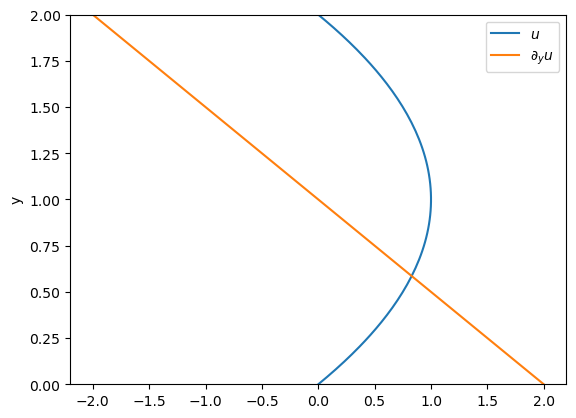

In [437]:
# Build domain
y_basis = de.Chebyshev('y', Ny, interval=(0, 2))
domain = de.Domain([y_basis], np.complex128)
y = domain.grid(0,scales=1)

U  = field.Field(domain, name='U')
Uy = field.Field(domain, name='Uy')

U['g'] = y*(2-y)
U.differentiate('y',out=Uy)
U.set_scales(1)
Uy.set_scales(1)
plt.plot(U['g'].real,y,label=r'$u$')
plt.plot(Uy['g'].real,y,label=r'$\partial_y u$')
plt.ylabel(r'y')
plt.ylim([0,2])
plt.legend()

## Set up the direct and adjoint problems

In [438]:
%%time
problemDirect = de.EVP(domain, eigenvalue='omega',variables=['u','uy','v','vy','w','wy','p'])
problemDirect.parameters['Re']    = Re
problemDirect.parameters['alpha'] = alpha
problemDirect.parameters['beta']  = beta
problemDirect.parameters['U'] = U
problemDirect.parameters['Uy'] = Uy

problemDirect.add_equation("omega*u + 1j*alpha*u*U + v*Uy + 1j*alpha*p + 1./Re*((alpha**2+beta**2)*u - dy(uy)) = 0")
problemDirect.add_equation("omega*v + 1j*alpha*v*U +        dy(p)      + 1./Re*((alpha**2+beta**2)*v - dy(vy)) = 0")
problemDirect.add_equation("omega*w + 1j*alpha*w*U +        1j*beta*p  + 1./Re*((alpha**2+beta**2)*w - dy(wy)) = 0")
problemDirect.add_equation("1j*alpha*u + vy + 1j*beta*w = 0")

problemDirect.add_equation("dy(u) - uy = 0")
problemDirect.add_equation("dy(v) - vy = 0")
problemDirect.add_equation("dy(w) - wy = 0")

problemDirect.add_bc("left(u) = 0")
problemDirect.add_bc("right(u) = 0")
problemDirect.add_bc("left(v) = 0")
problemDirect.add_bc("right(v) = 0")
problemDirect.add_bc("left(w) = 0")
problemDirect.add_bc("right(w) = 0")

EP_direct = Eigenproblem(problemDirect)
EP_direct.solve(sparse=False)

problemAdjoint = de.EVP(domain, eigenvalue='omega',variables=['u','uy','v','vy','w','wy','p'])
problemAdjoint.parameters['ReInv'] = 1./Re
problemAdjoint.parameters['alpha'] = alpha
problemAdjoint.parameters['beta']  = beta

problemAdjoint.parameters['U'] = U
problemAdjoint.parameters['Uy'] = Uy

problemAdjoint.add_equation("omega*u - 1j*alpha*u*U -        1j*alpha*p + ReInv*((alpha**2+beta**2)*u - dy(uy)) = 0")
problemAdjoint.add_equation("omega*v - 1j*alpha*v*U + u*Uy - dy(p)      + ReInv*((alpha**2+beta**2)*v - dy(vy)) = 0")
problemAdjoint.add_equation("omega*w - 1j*alpha*w*U -        1j*beta*p  + ReInv*((alpha**2+beta**2)*w - dy(wy)) = 0")
problemAdjoint.add_equation("-1j*alpha*u - vy - 1j*beta*w = 0")

problemAdjoint.add_equation("dy(u) - uy = 0")
problemAdjoint.add_equation("dy(v) - vy = 0")
problemAdjoint.add_equation("dy(w) - wy = 0")

problemAdjoint.add_bc("left(u) = 0")
problemAdjoint.add_bc("right(u) = 0")
problemAdjoint.add_bc("left(v) = 0")
problemAdjoint.add_bc("right(v) = 0")
problemAdjoint.add_bc("left(w) = 0")
problemAdjoint.add_bc("right(w) = 0")

EP_adjoint = Eigenproblem(problemAdjoint)
EP_adjoint.solve(sparse=False)

2022-11-30 14:20:25,479 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-11-30 14:20:25,508 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-11-30 14:21:06,309 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-11-30 14:21:06,333 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
CPU times: user 1min 20s, sys: 646 ms, total: 1min 20s
Wall time: 1min 21s


Text(0.5, 1.0, 'Adjoint')

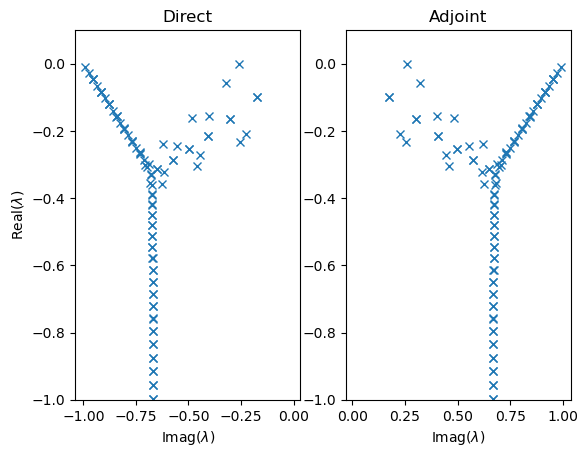

In [439]:
fig, ax = plt.subplots(1,2)

ax[0].plot(EP_direct.evalues.imag,EP_direct.evalues.real,'x')
ax[0].set_ylim([-1,0.1])
ax[0].set_xlabel(r'Imag($\lambda$)')
ax[0].set_ylabel(r'Real($\lambda$)')
ax[0].set_title(r'Direct')
ax[1].plot(EP_adjoint.evalues.imag,EP_adjoint.evalues.real,'x')
ax[1].set_ylim([-1,0.1])
ax[1].set_xlabel(r'Imag($\lambda$)')
ax[1].set_title(r'Adjoint')

In [440]:
idx = np.argmax(EP_direct.evalues.real)
most_unstable_direct = EP_direct.eigenmode(idx)

idx = np.argmax(EP_adjoint.evalues.real)
most_unstable_adjoint = EP_adjoint.eigenmode(idx)

In [441]:
norm = (np.conj(most_unstable_direct['u'])*most_unstable_direct['u']+np.conj(most_unstable_direct['v'])*most_unstable_direct['v']+np.conj(most_unstable_direct['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('Original norm',norm)
most_unstable_direct['u']['g'] /= np.sqrt(norm)
most_unstable_direct['v']['g'] /= np.sqrt(norm)
most_unstable_direct['w']['g'] /= np.sqrt(norm)
norm = (np.conj(most_unstable_direct['u'])*most_unstable_direct['u']+np.conj(most_unstable_direct['v'])*most_unstable_direct['v']+np.conj(most_unstable_direct['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('New norm',norm)

Original norm (0.005564270638442574+0j)
New norm (1.0000000000000007+0j)


In [442]:
norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('Original norm',norm)
most_unstable_adjoint['u']['g'] /= np.conj(norm)
most_unstable_adjoint['v']['g'] /= np.conj(norm)
most_unstable_adjoint['w']['g'] /= np.conj(norm)
norm = norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('New norm',norm)

Original norm (0.006539083946487178+0.0027288074920531805j)
New norm (1-1.970010868961503e-16j)


Text(0.5, 1.0, 'Adjoint')

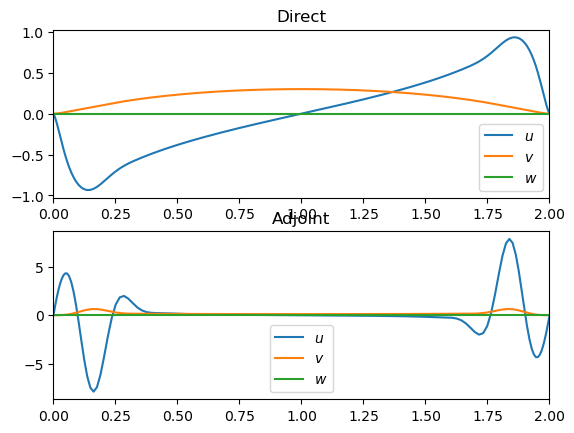

In [443]:
fig, ax = plt.subplots(2,1)

ax[0].plot(y,most_unstable_direct['u']['g'].real,label=r'$u$')
ax[0].plot(y,most_unstable_direct['v']['g'].real,label=r'$v$')
ax[0].plot(y,most_unstable_direct['w']['g'].real,label=r'$w$')
ax[0].legend()
ax[0].set_xlim([0,2])
ax[0].set_title('Direct')
ax[1].plot(y,most_unstable_adjoint['u']['g'].real,label=r'$u$')
ax[1].plot(y,most_unstable_adjoint['v']['g'].real,label=r'$v$')
ax[1].plot(y,most_unstable_adjoint['w']['g'].real,label=r'$w$')
ax[1].legend()
ax[1].set_xlim([0,2])
ax[1].set_title('Adjoint')

# Sensitivity analysis

In [444]:
def lap(u,v,w):
    uyy = de.operators.differentiate(u, y=2)
    vyy = de.operators.differentiate(v, y=2)
    wyy = de.operators.differentiate(w, y=2)
    u_lap = -(alpha**2+beta**2)*u + uyy
    v_lap = -(alpha**2+beta**2)*v + vyy
    w_lap = -(alpha**2+beta**2)*w + wyy
    return u_lap.evaluate(),v_lap.evaluate(),w_lap.evaluate()

In [445]:
u_lap, v_lap, w_lap = lap(most_unstable_direct['u'],most_unstable_direct['v'],most_unstable_direct['w'])

In [446]:
# Sensitivity wrt Re
dldRe = (np.conj(most_unstable_adjoint['u'])*u_lap+np.conj(most_unstable_adjoint['v'])*v_lap+np.conj(most_unstable_adjoint['w'])*w_lap).evaluate().integrate()['g'][0]
dldRe *= -1./Re**2
print('dl/dRe =',dldRe)

dl/dRe = (1.8128266580396835e-06+7.793596664273244e-06j)


In [447]:
EP_direct.evalues[np.argmax(EP_direct.evalues.real)]

(-6.935553349844157e-06-0.26126257021814475j)

In [467]:
%%time
Reynolds = np.linspace(500,12000,20)
growths = []
for Re_v in Reynolds:
    print('Solving for Re={}'.format(Re_v))
    EP_direct.solve(sparse=True,target=-0.26j,N=20, parameters={'Re':Re_v})
    max_growth = EP_direct.evalues[np.argmax(EP_direct.evalues.real)].real
    growths.append(max_growth)

Solving for Re=500.0
Solving for Re=1105.2631578947369
Solving for Re=1710.5263157894738
Solving for Re=2315.789473684211
Solving for Re=2921.0526315789475
Solving for Re=3526.315789473684
Solving for Re=4131.578947368422
Solving for Re=4736.842105263158
Solving for Re=5342.105263157895
Solving for Re=5947.368421052632
Solving for Re=6552.631578947368
Solving for Re=7157.894736842106
Solving for Re=7763.1578947368425
Solving for Re=8368.42105263158
Solving for Re=8973.684210526317
Solving for Re=9578.947368421053
Solving for Re=10184.21052631579
Solving for Re=10789.473684210527
Solving for Re=11394.736842105263
Solving for Re=12000.0
CPU times: user 2.22 s, sys: 35 ms, total: 2.26 s
Wall time: 2.26 s


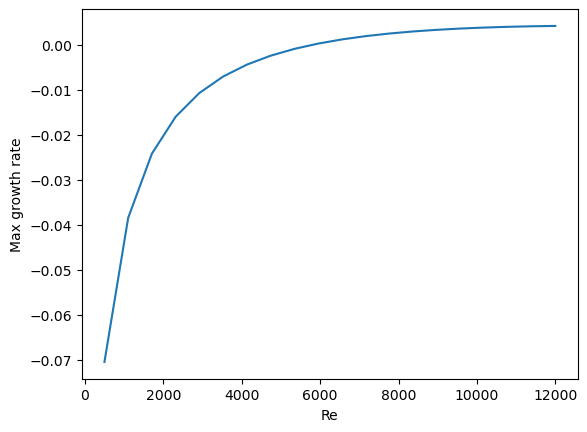

In [468]:
plt.plot(Reynolds,growths)
plt.xlabel(r'Re')
plt.ylabel(r'Max growth rate')
plt.savefig('growth_vs_Reynolds.png',dpi=150,bbox_inches='tight')